In [1]:
# Import the machine learning libraries.
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.6.9
Tensorflow version: 2.3.0
Keras version: 2.4.0


In [2]:
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteCF7VXD/rock_paper_scissors-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteCF7VXD/rock_paper_scissors-test.tfrecord


Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


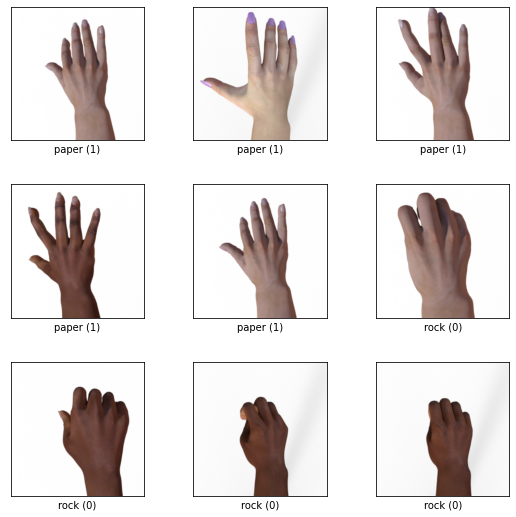

In [3]:
fig = tfds.show_examples(ds_info, ds_train)
classes = np.array(['rock', 'paper', 'scissors'])

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


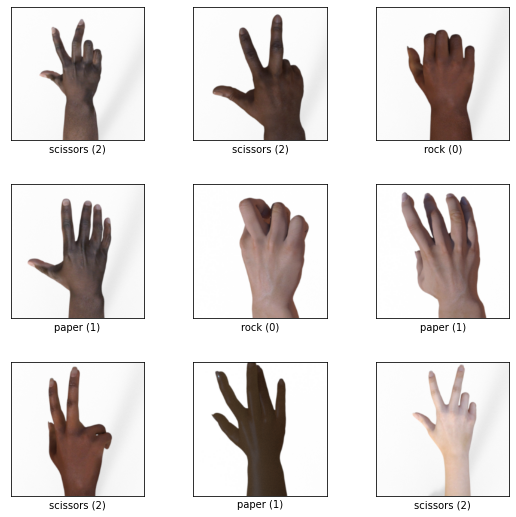

In [4]:
#reshaping of the image
INPUT_IMG_SIZE = 224
INPUT_IMG_SHAPE = (224, 224, 3)
#pre-processing of the input image 
def preprocess_image(sample):
    sample['image'] = tf.cast(sample['image'], tf.float32)
    sample['image'] = sample['image'] / 255.
    sample['image'] = tf.image.resize(sample['image'], [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return sample
#mapping
ds_train = ds_train.map(preprocess_image)
ds_test  = ds_test.map(preprocess_image)
#sample data 
fig = tfds.show_examples(ds_info, ds_train)

In [6]:
train_numpy = np.vstack(tfds.as_numpy(ds_train))
test_numpy = np.vstack(tfds.as_numpy(ds_test))

X_train = np.array(list(map(lambda x: x[0]['image'], train_numpy)))
y_train = np.array(list(map(lambda x: x[0]['label'], train_numpy)))

X_test = np.array(list(map(lambda x: x[0]['image'], test_numpy)))
y_test = np.array(list(map(lambda x: x[0]['label'], test_numpy)))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


(2520, 224, 224, 3) (2520,) (372, 224, 224, 3) (372,)


In [9]:
import tensorflow.keras.backend as K
K.clear_session()
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False, 
  pooling='avg'
)
base_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [10]:
base_model.trainable = False
model = tf.keras.models.Sequential()

model.add(base_model)

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(
    units=3,
    activation=tf.keras.activations.softmax
))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)
BATCH_SIZE=256

from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)
train_generator = train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE)

val_gen = ImageDataGenerator()
val_generator = val_gen.flow(X_test, y_test, batch_size=BATCH_SIZE)

In [12]:
n_epochs = 20

hist = model.fit(
    train_generator, 
    epochs=n_epochs,
    steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    validation_data=val_generator, 
    validation_steps=X_test.shape[0]//BATCH_SIZE
)

Epoch 1/20
9/9 [==============================] - 90s 10s/step - loss: 1.1496 - accuracy: 0.4686 - val_loss: 0.8828 - val_accuracy: 0.5742
Epoch 2/20
9/9 [==============================] - 89s 10s/step - loss: 0.6422 - accuracy: 0.7359 - val_loss: 0.5590 - val_accuracy: 0.7969
Epoch 3/20
9/9 [==============================] - 88s 10s/step - loss: 0.4007 - accuracy: 0.8516 - val_loss: 0.4518 - val_accuracy: 0.8555
Epoch 4/20
9/9 [==============================] - 88s 10s/step - loss: 0.2684 - accuracy: 0.9125 - val_loss: 0.3716 - val_accuracy: 0.9062
Epoch 5/20
9/9 [==============================] - 89s 10s/step - loss: 0.1963 - accuracy: 0.9390 - val_loss: 0.3392 - val_accuracy: 0.9023
Epoch 6/20
9/9 [==============================] - 88s 10s/step - loss: 0.1566 - accuracy: 0.9576 - val_loss: 0.3257 - val_accuracy: 0.9023
Epoch 7/20
9/9 [==============================] - 91s 10s/step - loss: 0.1422 - accuracy: 0.9625 - val_loss: 0.3248 - val_accuracy: 0.9180
Epoch 8/20
9/9 [===========

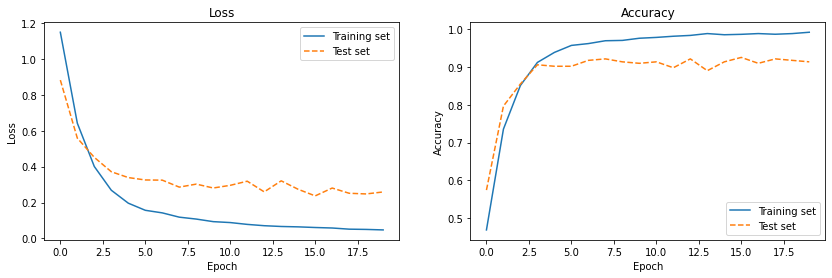

In [13]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()

In [14]:
base_model.trainable = True
len(base_model.layers)
fine_tune_at = 149

# freeze first layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# use a smaller training rate for fine-tuning
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(
    optimizer = opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 723,843
Non-trainable params: 1,537,984
_________________________________________________________________


In [15]:
n_epochs_fine = 10

hist_fine = model.fit( 
    train_generator, 
    epochs=n_epochs + n_epochs_fine,
    initial_epoch=n_epochs,  
    steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
    validation_data=val_generator, 
    validation_steps=X_test.shape[0]//BATCH_SIZE
)

Epoch 21/30
9/9 [==============================] - 96s 11s/step - loss: 0.0275 - accuracy: 0.9938 - val_loss: 0.2595 - val_accuracy: 0.9141
Epoch 22/30
9/9 [==============================] - 94s 10s/step - loss: 0.0201 - accuracy: 0.9969 - val_loss: 0.2598 - val_accuracy: 0.9180
Epoch 23/30
9/9 [==============================] - 94s 10s/step - loss: 0.0178 - accuracy: 0.9965 - val_loss: 0.2605 - val_accuracy: 0.9102
Epoch 24/30
9/9 [==============================] - 96s 11s/step - loss: 0.0131 - accuracy: 0.9978 - val_loss: 0.2006 - val_accuracy: 0.9336
Epoch 25/30
9/9 [==============================] - 95s 11s/step - loss: 0.0123 - accuracy: 0.9991 - val_loss: 0.2579 - val_accuracy: 0.9102
Epoch 26/30
9/9 [==============================] - 94s 10s/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 0.2419 - val_accuracy: 0.9102
Epoch 27/30
9/9 [==============================] - 94s 10s/step - loss: 0.0137 - accuracy: 0.9965 - val_loss: 0.2250 - val_accuracy: 0.9258
Epoch 28/30
9/9 [===

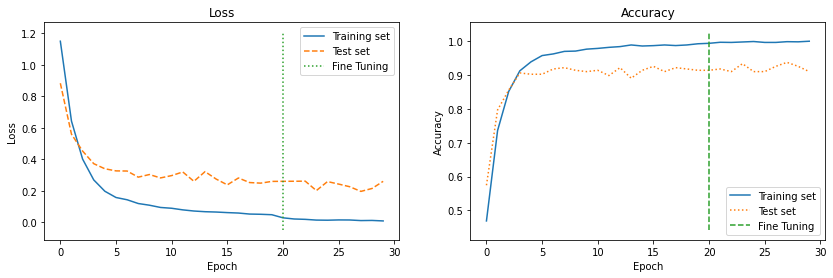

In [16]:
loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

accuracy = hist.history['accuracy'] + hist_fine.history['accuracy']
val_accuracy = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot([n_epochs, n_epochs], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='dotted')
plt.plot([n_epochs, n_epochs], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()